# **1. Model implementation**

## **1.1. Intergrating data**

,pChEMBL,Canomicalsmiles,0,1,2,3,4,5,6,7,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,10.000000,CCc1cc2c(=O)c3c4ccc(C#N)cc4[nH]c3n(C(C)C)c2cc1...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9.958607,CCc1cc2c(=O)c3c4ccc(C#N)cc4[nH]c3n(C(C)C)c2cc1...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.657577,CCc1cc2c(=O)c3c4ccc(C#N)cc4[nH]c3n(C(C)C)c2cc1...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.585027,CCCc1cc2c(=O)c3c4ccc(C#N)cc4[nH]c3n(C(C)C)c2cc...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.585027,CCc1cc2c(=O)c3c4ccc(C#N)cc4[nH]c3n(C(C)C)c2cc1...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,pChEMBL,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,10.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9.958607,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Data train: (1331, 2049)
Data test: (333, 2049)
***************************************************************************


,pChEMBL,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
635,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1319,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
542,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1419,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


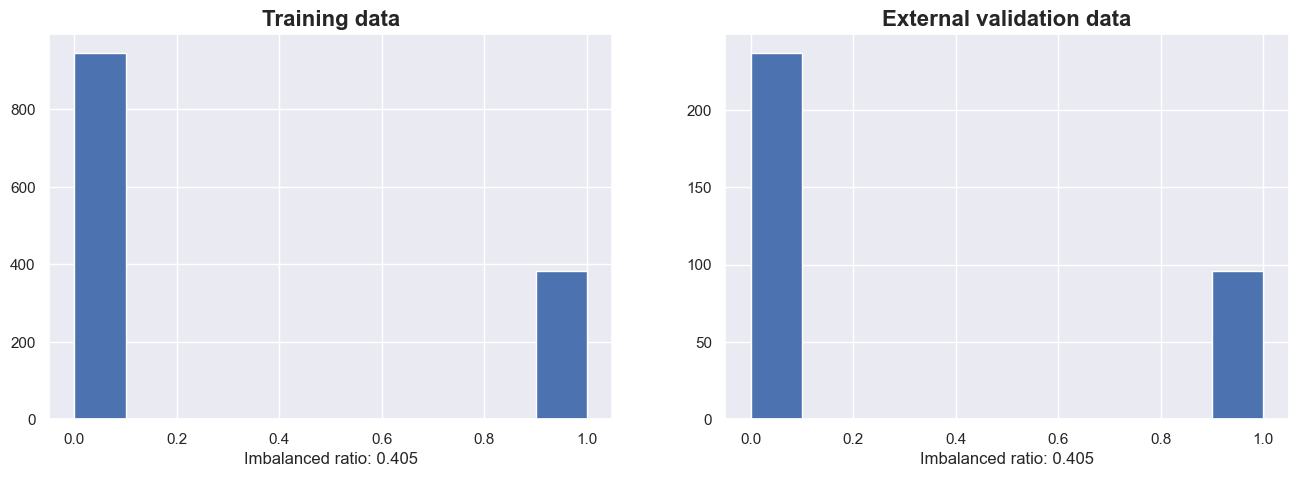

In [1]:
from Data_integration import Data_Itegration

integration = Data_Itegration(col_drop = "Canomicalsmiles", threshold = 7, y_name = "pChEMBL",
                             path = "Secfp_ro5.csv")

Data_train = integration.Data_train
Data_test = integration.Data_test

In [2]:
X_train = Data_train.iloc[:,1:2049]
y_train = Data_train["pChEMBL"]

X_test = Data_test.iloc[:, 1:2049]
y_test = Data_test["pChEMBL"]

## **1.2. Model cross validation**

In [3]:
from sklearn.model_selection import RepeatedStratifiedKFold,RepeatedKFold,cross_val_score
from sklearn.ensemble     import RandomForestClassifier
from xgboost              import XGBClassifier
from sklearn.neural_network import MLPClassifier

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

#Random forest
rf = RandomForestClassifier(random_state = 42)
scores_rf = cross_val_score(rf, X_train, y_train, scoring="f1", cv=cv, n_jobs=-1)

#XGBoost
xgb = XGBClassifier(random_state = 42, verbosity=0, use_label_encoder=False, eval_metrics ='logloss')
scores_xgb = cross_val_score(xgb, X_train, y_train, scoring="f1", cv=cv, n_jobs=-1)

#Catboost
mlp = MLPClassifier(alpha = 0.01, max_iter = 10000, validation_fraction = 0.1, random_state = 42, hidden_layer_sizes = 150)
scores_mlp = cross_val_score(mlp, X_train, y_train, scoring="f1", cv=cv, n_jobs=-1)

In [4]:
list_results = [scores_rf, scores_xgb, scores_mlp]
name = ["RandomForest","XGBoost", "MLP"]

# **2. Bayesian Estimation for Model Comparison**

In the realm of figuring out **the probability that one model is better than another**, Bayesian estimation emerges as a powerful statistical tool. This method involves defining a "prior," our initial beliefs about how differences in performance might be distributed. By combining this prior with a "likelihood function," which assesses how likely our observed differences are, Bayesian estimation produces a "posterior distribution." Notably, the approach suggested by Benavoli and colleagues stands out<sup>1</sup>. They propose using a Normal-Gamma distribution as the prior, making the math more manageable. This choice allows the posterior to be expressed as a straightforward Student’s t-distribution for the mean parameter, simplifying the interpretation of the results. In essence, Bayesian estimation offers a robust framework, and this specific approach streamlines the process of comparing models.


In this tutorial, we'll walk through the process using the `Statistical_test` package. Specifically, we'll create a `statistical_test` object and leverage its `bayesian_comparison` function to estimate 

In [5]:
from Statistical_test import statistical_test

# Input the list of models cross validation scores, names of your implemented models, X_train, and y_train with your actual data and training sets
model_compare = statistical_test(results = list_results, model =name,X_train = X_train, y_train = y_train)

Call the `bayesian_comparison` function to obtain the analysis dataframe
**Interpretation Content** of the dataframe:

- The **Better Probability** represents the likelihood that one model is superior to another. A high better probability instills confidence in the superiority of one model over the other.


- The **Worse Probability** is the likelihood that one model is inferior to another. A low worse probability complements a high better probability, providing a comprehensive view of model comparisons.


- **ROPE (Region of Practical Equivalence)** defines a range within which differences in model performance are deemed practically equivalent. For instance, a 1% difference might be considered negligible for practical purposes, fostering a nuanced understanding of model distinctions.


- The **p-value** is a statistical metric. A low p-value suggests that the observed differences are improbable under the assumption of no effect, leading to the rejection of the null hypothesis. In Bayesian estimation, it aids in assessing the significance of model differences.


- The **t-statistic** serves as a measure to determine if observed differences are statistically significant. Larger absolute values in the t-statistic provide more confidence in the significance of observed differences, contributing to the robustness of model comparisons.


In [6]:
bayesian_df = model_compare.bayesian_comparison()

,model_1,model_2,t_stat,p_val,worse_prob,better_prob,rope_prob
0,RandomForest,XGBoost,-1.139,0.396,0.711,0.048,0.241
1,RandomForest,MLP,-0.507,0.924,0.521,0.172,0.306
2,XGBoost,MLP,0.517,0.914,0.136,0.465,0.399


# **3. Wilcoxon signed rank test for Model Comparison**

The Wilcoxon signed-rank test is a popular choice for comparing the performance of machine learning models due to its robustness and versatility. Here are some key reasons why it is often preferred over other statistical tests:
- **Non-parametric Nature**: Unlike parametric tests like the paired t-test, the Wilcoxon signed-rank test does not make any assumptions about the underlying distribution of the data. This is particularly useful in machine learning, where data distributions can be non-normal or even multimodal.

- **Robustness to Outliers**: The Wilcoxon signed-rank test is less sensitive to outliers compared to parametric tests. Outliers can significantly impact the results of parametric tests, potentially skewing the comparison between models. The Wilcoxon signed-rank test's ranking-based approach is less influenced by extreme values.

- **Suitability for Paired Data**: The Wilcoxon signed-rank test is specifically designed for analyzing paired data, where each observation in one dataset has a corresponding observation in the other dataset. This makes it ideal for comparing machine learning models, where performance is typically evaluated on paired input-output data.

- **Versatility across Performance Metrics**: The Wilcoxon signed-rank test can be used to compare machine learning models based on various performance metrics, such as accuracy, precision, recall, or F1-score. It is not restricted to comparing models based on a single metric, allowing for a more comprehensive assessment of performance differences.

### Interpretation of P-value Ranges

The interpretation of p-values depends on the strength of evidence against the null hypothesis. Here's a summary of the different ranges of p-values and their corresponding interpretations:

| P-value Range | Interpretation |
|---|---|
| `< 0.001` | Extremely strong evidence against the null hypothesis |
| `0.001 < p-value < 0.01` | Strong evidence against the null hypothesis |
| `0.01 < p-value < 0.05` | Moderate evidence against the null hypothesis |
| `0.05 < p-value < 0.10` | Weak evidence against the null hypothesis |
| `p-value > 0.10` | No evidence against the null hypothesis |


My `Statistical_test` package has a `wilcoxon_comparison` function that obtains p-values when comparing models in pairs.

In [7]:
df_pvalue = model_compare.wilcoxon_comparison()
df_pvalue

/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,RandomForest,XGBoost,MLP
RandomForest,1.000000,0.009669,0.177193
XGBoost,0.009669,1.000000,0.171648
MLP,0.177193,0.171648,1.000000


We can create a boxplot to visualize the distribution of scores and plotting the Wilcoxon p-value on this boxplot. Using `boxplot_comparison` to obtain the boxplot

/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


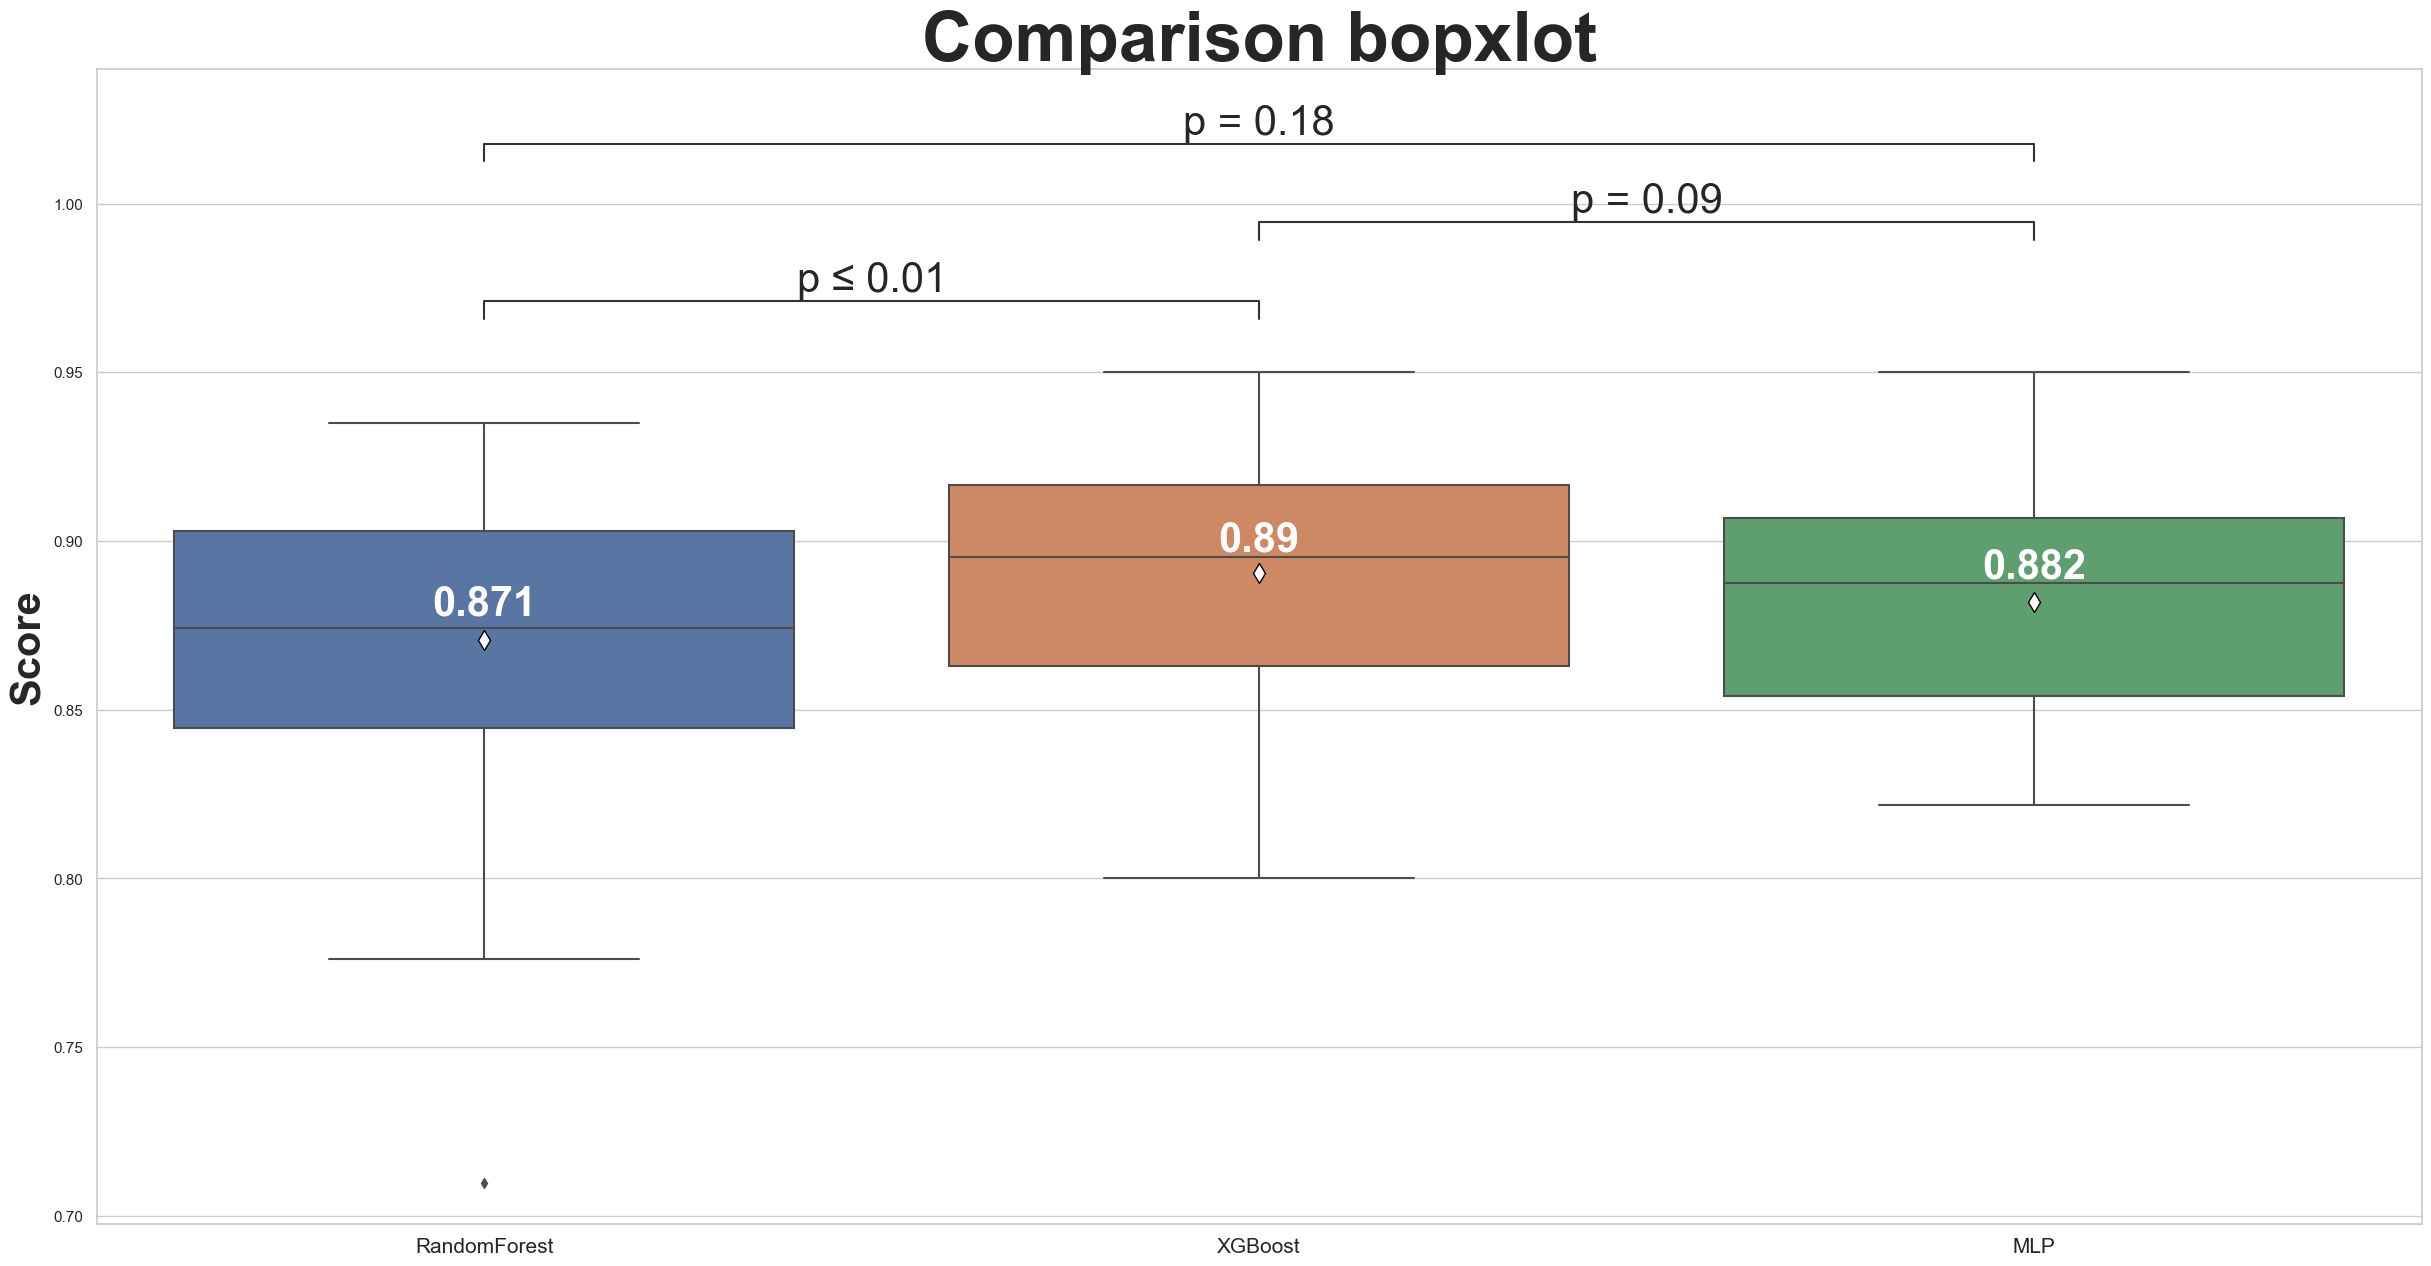

In [8]:
model_compare.boxplot_comparision(show_pvalue = True)

When comparing a large amount of models, boxplot visualization is not suitable. To address this scenario, heatmap is a better choice for visualization. By using `posthoc_comparison` function, we can plot our heatmap.

/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


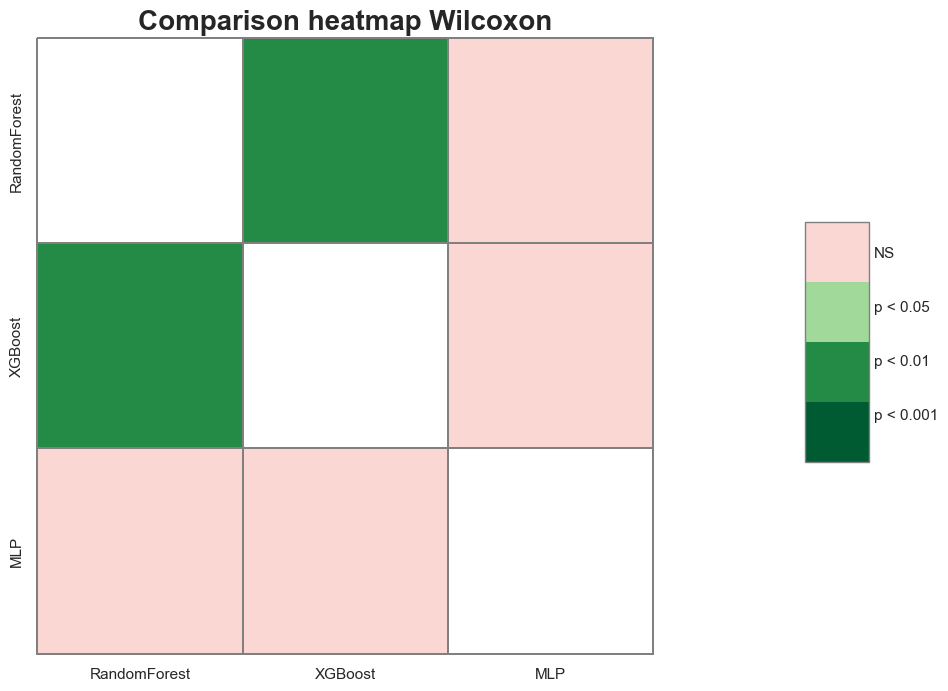

In [9]:
model_compare.posthoc_comparison(title = "Comparison heatmap Wilcoxon", save = False)

In [10]:
model_compare.model_scores

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Name,,,,,,,,,,,,,,,,,,,,,
RandomForest,0.895522,0.861111,0.820513,0.883721,0.904110,0.823529,0.931034,0.831169,0.886364,0.894737,...,0.860759,0.901408,0.921053,0.860215,0.902439,0.931507,0.860759,0.709677,0.935065,0.830769
XGBoost,0.878788,0.857143,0.857143,0.919540,0.901408,0.894118,0.881356,0.860759,0.896552,0.933333,...,0.839506,0.916667,0.933333,0.888889,0.925000,0.935065,0.897436,0.800000,0.950000,0.869565
MLP,0.885714,0.857143,0.867470,0.906977,0.849315,0.888889,0.842105,0.886076,0.860465,0.904110,...,0.833333,0.916667,0.911392,0.866667,0.950000,0.911392,0.839506,0.838710,0.925000,0.852941


# **4. Multiple models comparison**

## **4.1. Multiple cross validation**

In this section, let's compare the performance of 15 machine learning models. Using my `Model_selection` package, automated cross-validation is performed.

In [11]:
from Model_selection import model_selection

#task "C" means classification, score is the evaluated metrics
cv_f1 = model_selection(X_train, y_train,task= "C", score = 'f1')
cv_f1.case_model()
cv_f1.compare()

>Logic 0.878 (0.038)
>KNN 0.783 (0.059)


/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or

>SVM 0.856 (0.041)
>GaussianNB 0.655 (0.046)
>BernoulliNB 0.741 (0.039)
>LDA 0.719 (0.060)


/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


>QDA 0.688 (0.054)
>DTree 0.711 (0.060)
>RF 0.865 (0.041)
>ExT 0.874 (0.039)
>ADA 0.846 (0.043)
>Grad 0.868 (0.039)


/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>XGB 0.886 (0.037)


/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>Catbst 0.885 (0.034)
>MLP 0.877 (0.036)


In [12]:
#Obtain results
mutil_results = cv_f1.results
model_names = cv_f1.names

## **4.2. Statistical analysis**

In [13]:
from Statistical_test import statistical_test

# Input the list of models cross validation scores, names of your implemented models, X_train, and y_train with your actual data and training sets
multi_compare = statistical_test(results = mutil_results, model =model_names,X_train = X_train, y_train = y_train)

### **4.2.1. Bayesian estimation**

In [14]:
#Bayesian estimation dataframe
bayesian_df_multi = multi_compare.bayesian_comparison()

,model_1,model_2,t_stat,p_val,worse_prob,better_prob,rope_prob
0,Logic,KNN,2.697,0.605,0.003,0.989,0.008
1,Logic,SVM,1.213,1.000,0.043,0.740,0.217
2,Logic,GaussianNB,11.771,0.000,0.000,1.000,0.000
3,Logic,BernoulliNB,5.409,0.000,0.000,1.000,0.000
4,Logic,LDA,4.386,0.007,0.000,1.000,0.000
...,...,...,...,...,...,...,...
100,Grad,Catbst,-1.843,1.000,0.769,0.003,0.228
101,Grad,MLP,-0.485,1.000,0.459,0.146,0.395
102,XGB,Catbst,0.042,1.000,0.226,0.251,0.523
103,XGB,MLP,0.509,1.000,0.148,0.481,0.371


### **4.2.2. Wilconxon signed rank test**

#### **a. Calculating p-value**

In [15]:
df_pvalue_multi = multi_compare.wilcoxon_comparison()
df_pvalue_multi

/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,Logic,KNN,SVM,GaussianNB,BernoulliNB,LDA,QDA,DTree,RF,ExT,ADA,Grad,XGB,Catbst,MLP
Logic,1.000000e+00,1.955777e-07,5.541493e-02,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07,1.000000e+00,1.000000e+00,2.370732e-03,6.410361e-01,1.000000e+00,1.000000e+00,1.000000e+00
KNN,1.955777e-07,1.000000e+00,3.352761e-07,2.346933e-07,1.188469e-02,4.435576e-02,1.687182e-04,4.892051e-05,7.301569e-07,7.301569e-07,1.588453e-03,8.359551e-06,1.955777e-07,3.352761e-07,4.164875e-06
SVM,5.541493e-02,3.352761e-07,1.000000e+00,1.955777e-07,1.955777e-07,7.301569e-07,1.955777e-07,2.346933e-07,1.000000e+00,1.432524e-01,1.000000e+00,1.000000e+00,1.921944e-02,2.538292e-03,1.044680e-01
GaussianNB,1.955777e-07,2.346933e-07,1.955777e-07,1.000000e+00,3.352761e-07,1.433276e-03,3.051827e-01,3.454037e-03,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07
BernoulliNB,1.955777e-07,1.188469e-02,1.955777e-07,3.352761e-07,1.000000e+00,1.000000e+00,1.588453e-03,3.455841e-01,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07
LDA,1.955777e-07,4.435576e-02,7.301569e-07,1.433276e-03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.955777e-07,1.955777e-07,5.308539e-07,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07
QDA,1.955777e-07,1.687182e-04,1.955777e-07,3.051827e-01,1.588453e-03,1.000000e+00,1.000000e+00,1.000000e+00,1.955777e-07,1.955777e-07,2.346933e-07,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07
DTree,1.955777e-07,4.892051e-05,2.346933e-07,3.454037e-03,3.455841e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.955777e-07,1.955777e-07,3.257766e-06,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07
RF,1.000000e+00,7.301569e-07,1.000000e+00,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07,1.000000e+00,1.000000e+00,9.936044e-01,1.000000e+00,1.058738e-01,1.432524e-01,1.000000e+00
ExT,1.000000e+00,7.301569e-07,1.432524e-01,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07,1.955777e-07,1.000000e+00,1.000000e+00,1.044680e-01,1.000000e+00,6.913507e-01,9.936044e-01,1.000000e+00


#### **b. Boxplot comparison**

/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


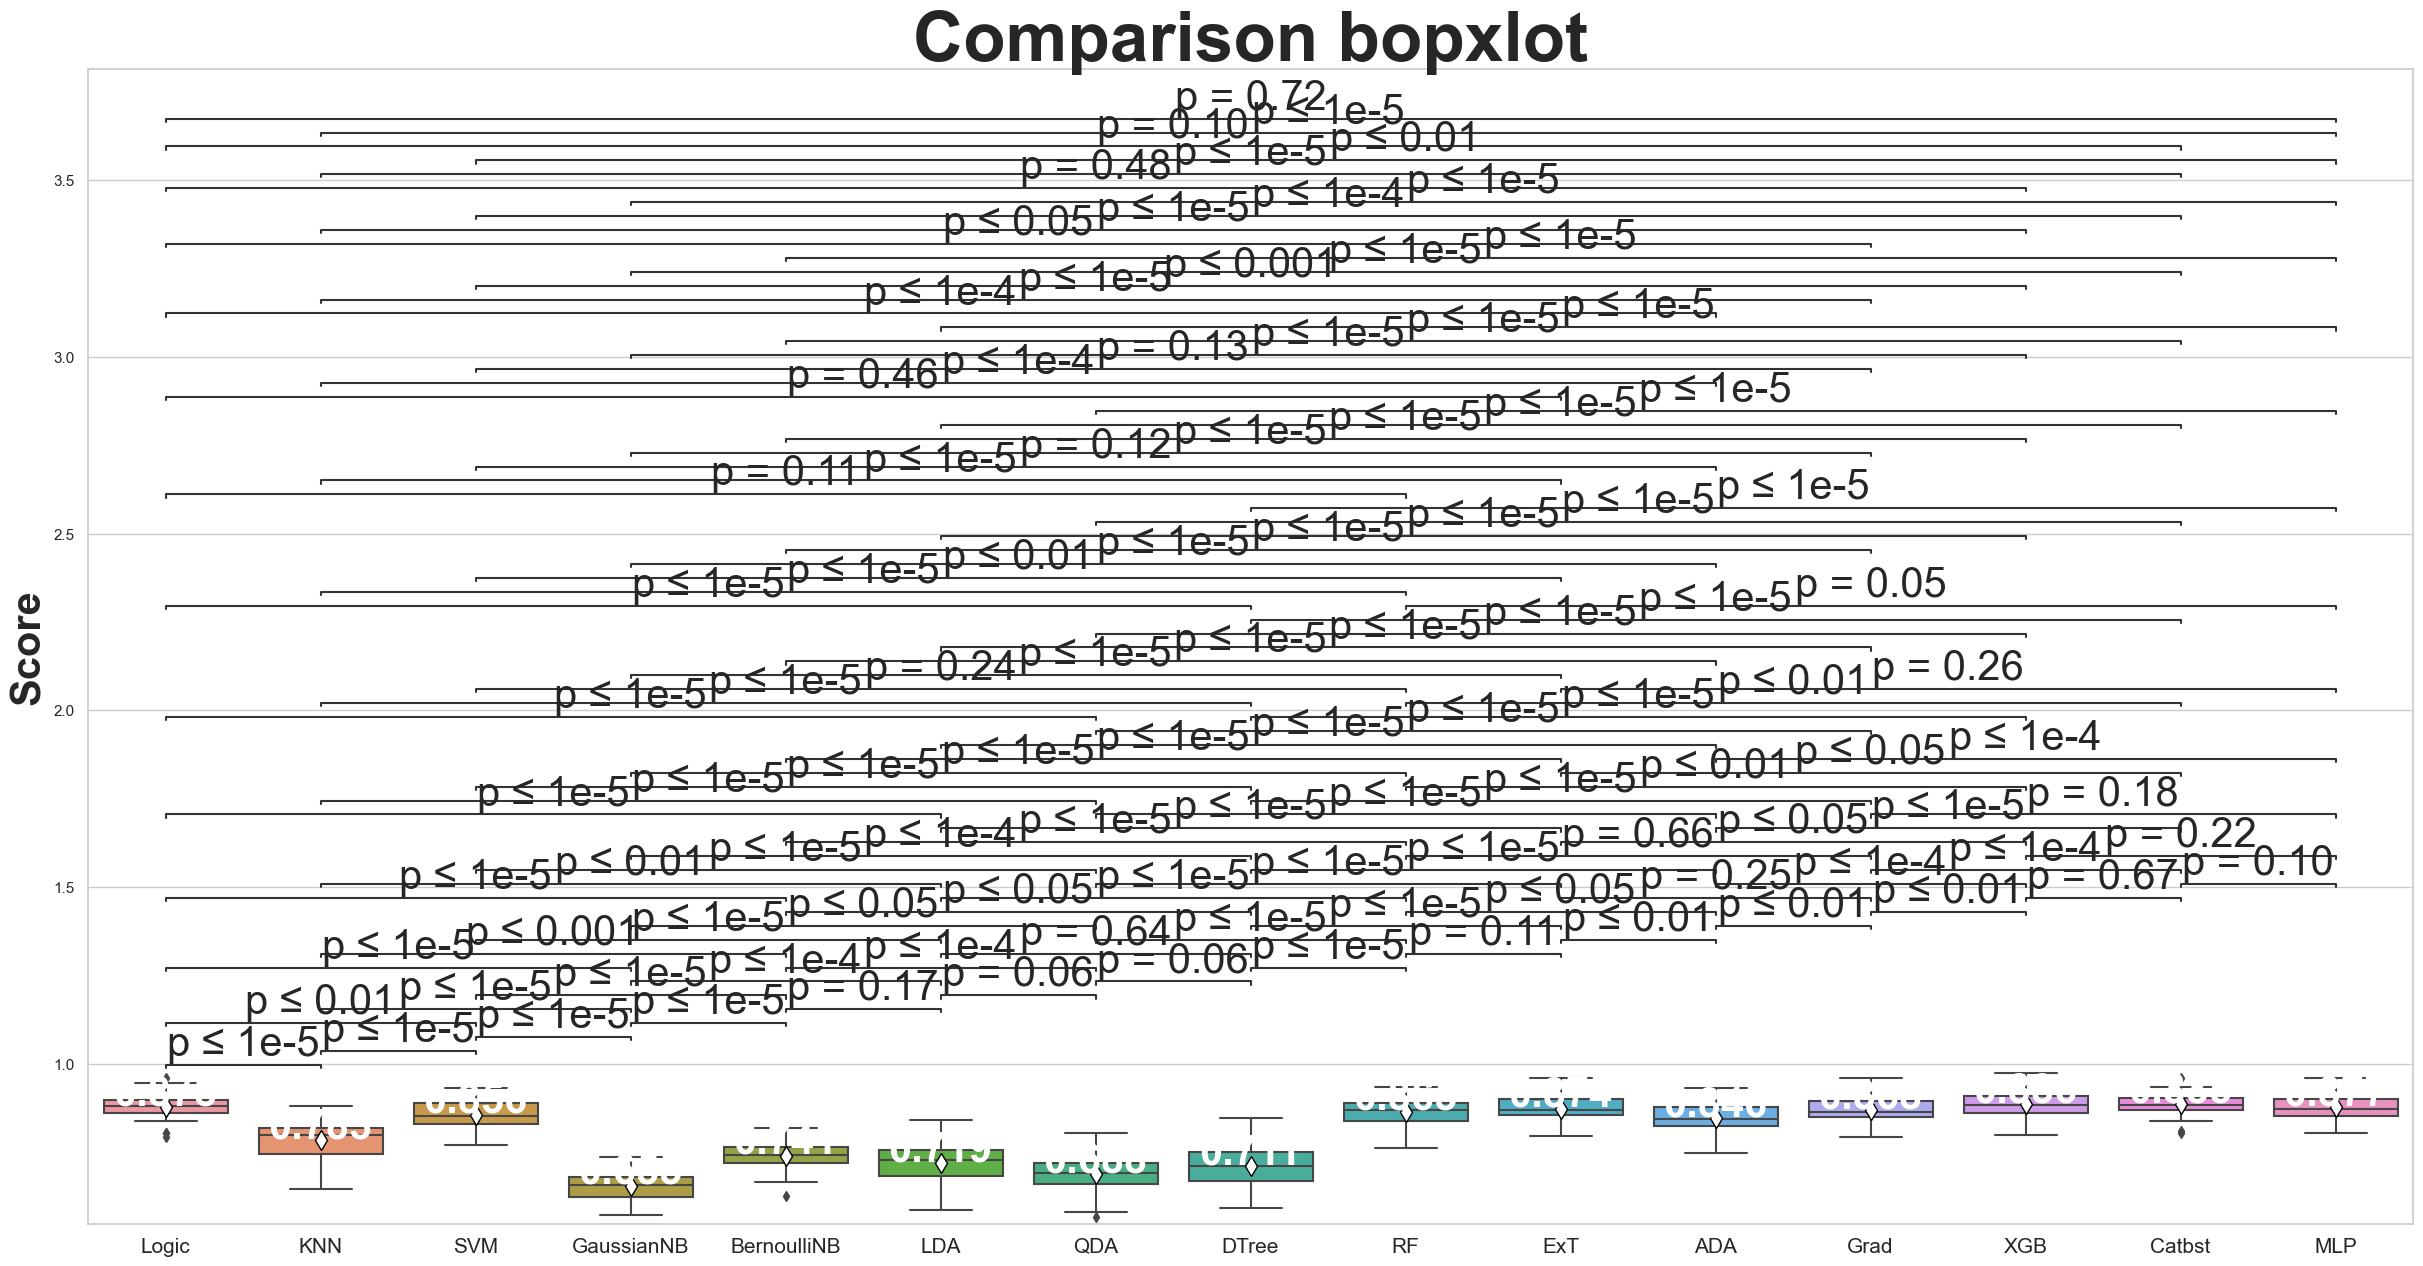

In [22]:
multi_compare.boxplot_comparision(show_pvalue = True)

/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


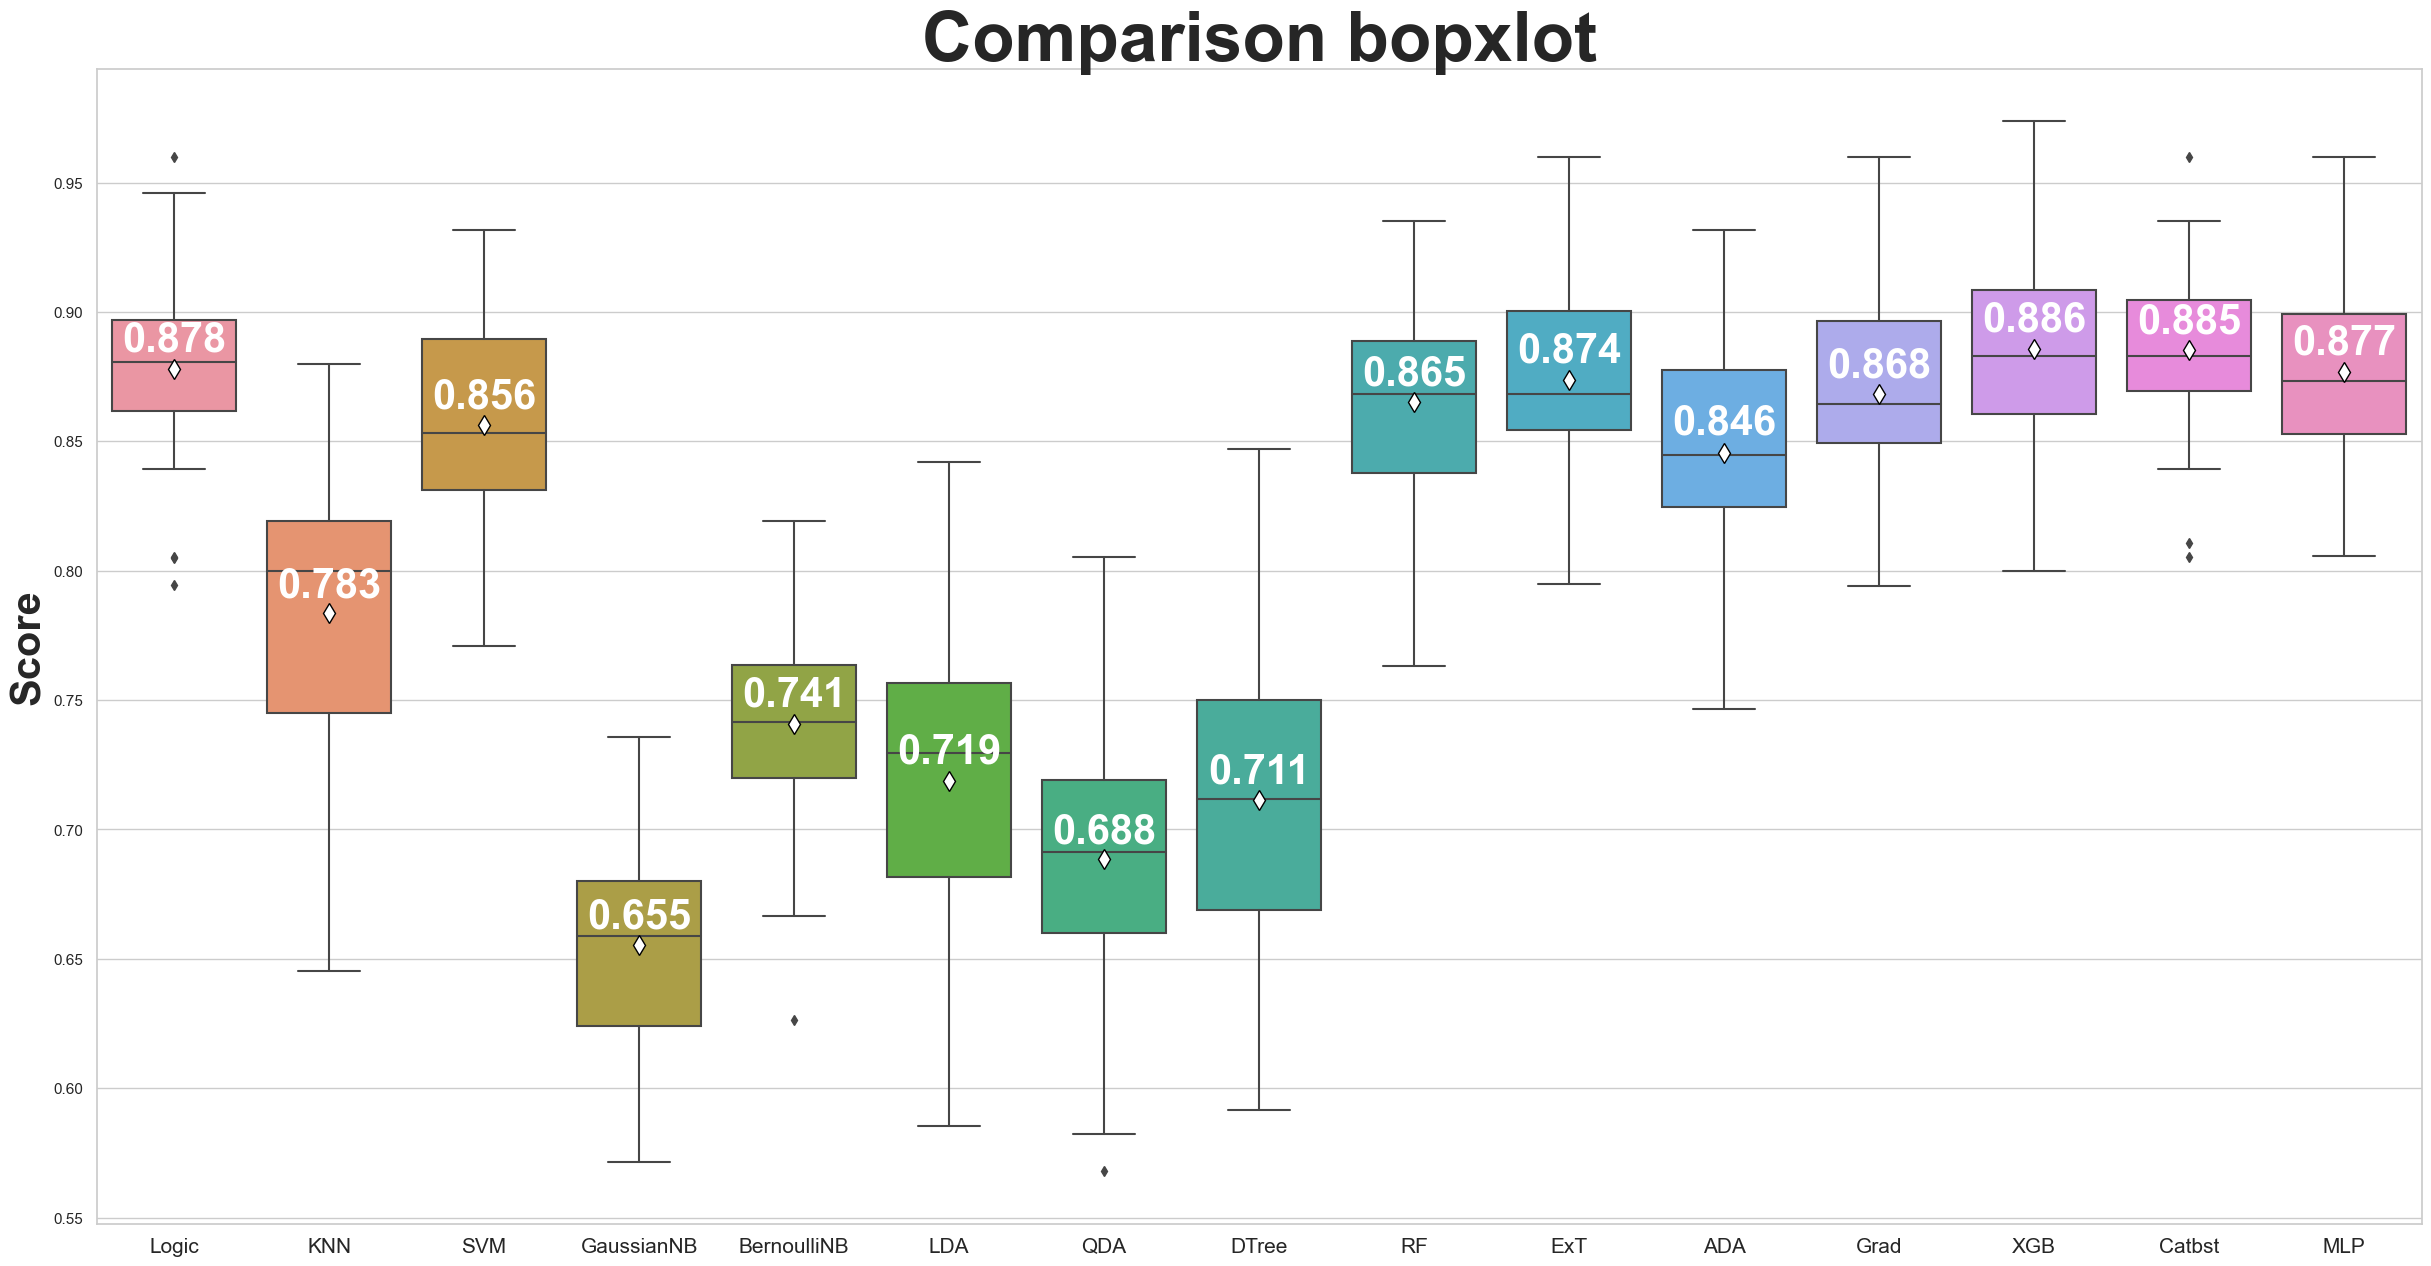

In [23]:
multi_compare.boxplot_comparision(show_pvalue = False)

#### **c. Heatmap comparison**

As you can see in this case, analyzing the results based on this messy boxplot is quite challenging. Consequently, I recommend using **a heatmap** to analyze the p-values to gain insights into these results

/Users/thechuongtrinh/anaconda3/envs/cheminformatics/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


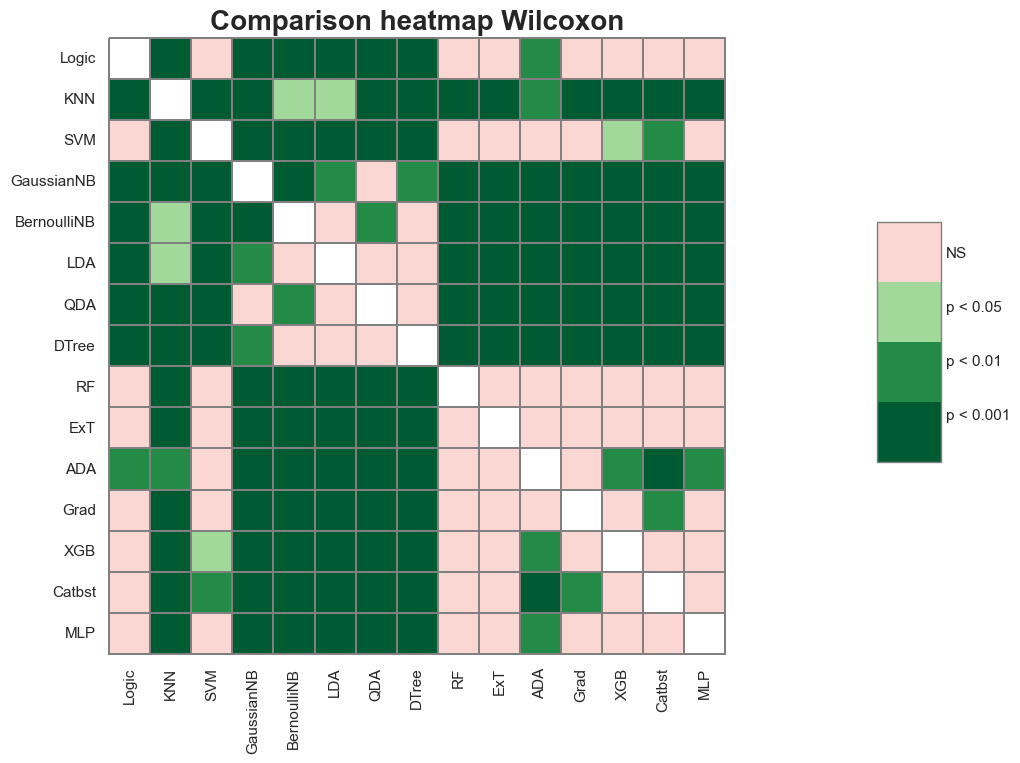

In [24]:
multi_compare.posthoc_comparison(title = "Comparison heatmap Wilcoxon", save = False)